# Surviving the Titanic

The purpose of this project is to create a machine learning model to predict whether or not a passenger survived the sinking of the Titanic. Data is from the [Kaggle Titanic dataset](https://www.kaggle.com/c/titanic).

In [1]:
#Read in data
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2]:
# Feature engineering
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
#Process data
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    cols = ["Age_categories", "Fare_categories", "Title", "Cabin_type", "Sex"]
    for col in cols:
        df = create_dummies(df, col)
    return df
train_p = process_df(train)
holdout_p = process_df(holdout)

(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

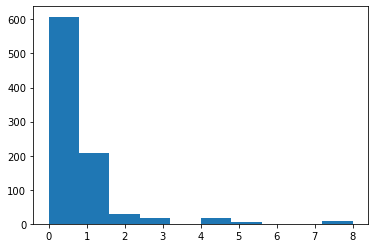

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(train_p["SibSp"])

In [5]:
train_p["SibSp"].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

(array([678., 118.,   0.,  80.,   0.,   5.,   4.,   0.,   5.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

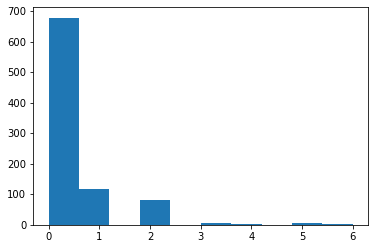

In [6]:
plt.hist(train_p["Parch"])

In [7]:
train_p["Parch"].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

Neither the Sibling/Spouse nor the Parent/Children columns seem particularly informative. Both distributions show a decided left skew and low overall variance. Perhaps a more informative feature can be created by combining the two into a Relatives column.

(array([537., 161., 102.,  29.,  15.,  22.,  12.,   6.,   0.,   7.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

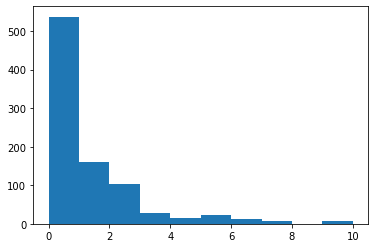

In [8]:
train_p["Relatives"] = train_p["SibSp"] + train_p["Parch"]
plt.hist(train_p["Relatives"])

In [9]:
train_p["Relatives"].describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: Relatives, dtype: float64

While there is a still a decided left skew to the newly engineered Relatives column, it displays signifcantly more variance then the Sibling/Spouse and Parent/Children columns on their own. Let's examine how it correlates with Survival.

In [10]:
pd.pivot_table(train_p, index="Relatives", values="Survived")

,Survived
Relatives,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


The number of family members you travelled with turns out to be highly predictive of your chances of your survival. In particular, people who travelled alone (~30% chance of surival) or in groups of 4 or more (<20% chance of survival) had relatively poor chances of surival compared to those who only traveled with a few family members.

In [11]:
# Create relative dummy variables
def relatives(df):
    df["Relatives"] = df["SibSp"] + df["Parch"]
    df = create_dummies(df, "Relatives")
    return df

train_r = relatives(train_p)
holdout_r = relatives(holdout_p)
train_r.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Age_categories',
       'Fare_categories', 'Title', 'Cabin_type', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'Relatives', 'Relatives_0', 'Relatives_1',
       'Relatives_2', 'Relatives_3', 'Relatives_4', 'Relatives_5',
       'Relatives_6', 'Relatives_7', 'Relatives_10'],
      dtype='object')

In [12]:
# Drop dummy columns
cols = ["Age_categories_Missing", "Fare_categories_100+", "Title_Royalty",
       "Cabin_type_Unknown", "Sex_male", "Relatives_7"]
train_r = train_r.drop(cols, axis=1)
holdout_r = holdout_r.drop(cols, axis=1)
holdout_r.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Age_categories', 'Fare_categories',
       'Title', 'Cabin_type', 'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Sex_female', 'Relatives',
       'Relatives_0', 'Relatives_1', 'Relatives_2', 'Relatives_3',
       'Relatives_4', 'Relatives_5', 'Relatives_6', 'Relatives_10'],
      dtype='object')

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes(["number"])
    df = df.dropna(axis=1)
    all_X = df.drop(["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = list(all_X.columns[selector.support_])
    print(optimized_columns)
    return optimized_columns

optimized_columns = select_features(train_r)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Sex_female', 'Relatives', 'Relatives_0', 'Relatives_1', 'Relatives_2', 'Relatives_3', 'Relatives_4', 'Relatives_5']


In [14]:
# Grid search for best model

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    models = [
    {
        "name": "LogisticRegression", 
        "estimator": LogisticRegression(),
        "hyperparameters":
        {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }
    },
    {
        "name": "KNeighborsClassifer",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1, 2]
        }
    },
    {
        "name": "RandomForestClassifer",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    }
    ]

    for n in range(3):
        print(models[n]["name"])
        grid = GridSearchCV(models[n]["estimator"], 
                            param_grid=models[n]["hyperparameters"],
                            cv=10)
        grid.fit(all_X, all_y)
        models[n]["best_score"] = grid.best_score_
        models[n]["best_params"] = grid.best_params_
        models[n]["best_estimator"] = grid.best_estimator_
        print(grid.best_params_, grid.best_score_)
        
    return models

best_models = select_model(train_r, optimized_columns)

LogisticRegression
{'solver': 'lbfgs'} 0.8226711560044894
KNeighborsClassifer


C:\Users\Adam\Miniconda3\envs\minimal_ds\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1, 'weights': 'distance'} 0.7699214365881033
RandomForestClassifer
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9} 0.8406285072951739


C:\Users\Adam\Miniconda3\envs\minimal_ds\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
submit_model = best_models[2]["best_estimator"]
submit_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=9,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
# Submit best model
import csv
def save_submission_file(df, estimator, features, filename=None):
    predictions = estimator.predict(df[features])
    data_dict = {
        "PassengerID": df["PassengerId"],
        "Survived": predictions
    }
    submission = pd.DataFrame(data_dict)
    return submission.to_csv(filename, index=False)

submission = save_submission_file(holdout_r, submit_model, optimized_columns, 
                                  filename="submission.csv")